# EYE BLINK DETECTION:
# 1) Simple Model
Based on tutorial:  
https://www.pyimagesearch.com/2017/04/24/eye-blink-detection-opencv-python-dlib/

For every session, unfound packages have to be installed. You can install unfound packages via !pip install command i.e.  
> !pip install opencv-python  
> !pip install cmake dlib  
> !pip install --upgrade imutils

Opencv and dlib comes with pre-installed in kaggle environement so installing only imutils would be enough.

**Initialization of the Code:**

Necesarry installations, imports and definitions. 

Basic model uses dlib's "get_frontal_face_detector" to detect faces. It uses HoG and SVM methods.  
http://dlib.net/python/index.html#dlib.get_frontal_face_detector

Basic model also uses dlib's "shape_predictor". It's implementation of [paper by Kazemi and Sullivan (2014).](https://www.semanticscholar.org/paper/One-millisecond-face-alignment-with-an-ensemble-of-Kazemi-Sullivan/d78b6a5b0dcaa81b1faea5fb0000045a62513567)
http://dlib.net/python/index.html#dlib.shape_predictor

You can download a trained facial landmark predictor from:  
http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

Or train your own by:  
http://dlib.net/train_shape_predictor.py.html

In [1]:
# install imutils
!pip install --upgrade imutils

# import packages
from scipy.spatial import distance as dist
import imutils
from imutils import face_utils
import numpy as np
import pandas as pd
import dlib
import cv2
import os
import time
import h5py
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

# define three constants. 
# You can later experiment with these constants by changing them to adaptive variables.
EAR_THRESHOLD = 0.21 # eye aspect ratio to indicate blink
EAR_CONSEC_FRAMES = 3 # number of consecutive frames the eye must be below the threshold
SKIP_FIRST_FRAMES = 0 # how many frames we should skip at the beggining

# initialize dlib variables
dlib_detector = dlib.get_frontal_face_detector()
dlib_predictor = dlib.shape_predictor("../input/shape_predictor_68_face_landmarks.dat")

# initialize output structures
scores_string = ""

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=8c5f20d747a0a6b2c42b5d91387cdc821a0e650fd14664daa2c4d64653d6e135
  Stored in directory: /root/.cache/pip/wheels/27/4d/3a/6dcdf7c3ebc87bf1ae013d96c9cf060ccfe334bb5ee769f377
Successfully built imutils


**Datasets are ready-to-use in "../input" folder. Let's take a look at them.**  
> yawning.avi --> a test video from NTHU dataset (no annotations)  
> shape_predictor_68_face_landmarks.dat --> model of dlib's face predictor  
> eyeblink8 folder --> 8 videos with annotations for blink detection purposes made by https://www.blinkingmatters.com/research  
> talkingFace folder --> 1 video with annotation for blink detection purposes made by https://www.blinkingmatters.com/research

You can run this section **to see content of input folder:**

In [2]:
# print content of any folder
def display_folder(path):
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            print(os.path.join(dirname, filename))

In [3]:
# print content of "../input" folder
display_folder("../input")

../input/yawning.avi
../input/shape_predictor_68_face_landmarks.dat
../input/eyeblink8/9/27122013_152435_cam.tag
../input/eyeblink8/9/27122013_152435_cam.txt
../input/eyeblink8/9/27122013_152435_cam.avi
../input/eyeblink8/2/26122013_224532_cam.tag
../input/eyeblink8/2/26122013_224532_cam.txt
../input/eyeblink8/2/26122013_224532_cam.avi
../input/eyeblink8/8/27122013_151644_cam.tag
../input/eyeblink8/8/27122013_151644_cam.avi
../input/eyeblink8/8/27122013_151644_cam.txt
../input/eyeblink8/3/26122013_230103_cam.tag
../input/eyeblink8/3/26122013_230103_cam.txt
../input/eyeblink8/3/26122013_230103_cam.avi
../input/eyeblink8/1/26122013_223310_cam.avi
../input/eyeblink8/1/26122013_223310_cam.tag
../input/eyeblink8/1/26122013_223310_cam.txt
../input/eyeblink8/10/27122013_153916_cam.tag
../input/eyeblink8/10/27122013_153916_cam.avi
../input/eyeblink8/10/27122013_153916_cam.txt
../input/eyeblink8/4/26122013_230654_cam.tag
../input/eyeblink8/4/26122013_230654_cam.txt
../input/eyeblink8/4/26122013

**We define a function that calculates EAR values:**

It's an implementation of [paper by Soukupova and Cech (2016).](http://vision.fe.uni-lj.si/cvww2016/proceedings/papers/05.pdf)

In [4]:
# define ear function
def eye_aspect_ratio(eye):
    # compute the euclidean distances between the two sets of
    # vertical eye landmarks (x, y)-coordinates
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    # compute the euclidean distance between the horizontal
    # eye landmark (x, y)-coordinates
    C = dist.euclidean(eye[0], eye[3])
    # compute the eye aspect ratio
    ear = (A + B) / (2.0 * C)
    # return the eye aspect ratio
    return ear

**We define a function that reads a video and calculate it's EAR values**:  

In [5]:
# process a given video file 
def process_video(input_file,detector=dlib_detector,predictor=dlib_predictor,\
                  lStart=42,lEnd=48,rStart=36,rEnd=42,ear_th=0.21,consec_th=3, up_to = None):
    #define necessary variables
    COUNTER = 0
    TOTAL = 0
    current_frame = 1
    blink_start = 0
    blink_end = 0
    closeness = 0
    output_closeness = []
    output_blinks = []
    blink_info = (0,0)
    processed_frames = []
    frame_info_list = []

    #define capturing method
    cap = cv2.VideoCapture(input_file)
    time.sleep(1.0)
    
    #build a dictionary video_info
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count/fps
    video_info_dict = {
                'fps': fps,
                'frame_count': frame_count,
                'duration(s)': duration,
            }

    while True:
        # grab the frame from the threaded video file stream, resize
        # it, and convert it to grayscale
        # channels)
        (grabbed, frame) = cap.read()
        if not grabbed:
            break
        height = frame.shape[0]
        weight = frame.shape[1]
        frame = cv2.resize(frame, (480, int(480*height/weight)))
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # detect faces in the grayscale frame
        rects = detector(gray, 0)

        # loop over the face detections
        for rect in rects:
            # determine the facial landmarks for the face region, then
            # convert the facial landmark (x, y)-coordinates to a NumPy
            # array
            shape = predictor(gray, rect)
            shape = np.array([[p.x,p.y] for p in shape.parts()])
            # extract the left and right eye coordinates, then use the
            # coordinates to compute the eye aspect ratio for both eyes
            leftEye = shape[lStart:lEnd]
            rightEye = shape[rStart:rEnd]
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)
            # average the eye aspect ratio together for both eyes
            ear = (leftEAR + rightEAR) / 2.0

            # compute the convex hull for the left and right eye, then
            # visualize each of the eyes
            leftEyeHull = cv2.convexHull(leftEye)
            rightEyeHull = cv2.convexHull(rightEye)
            cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
            cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

            # check to see if the eye aspect ratio is below the blink
            # threshold, and if so, increment the blink frame counter
            if ear < ear_th:
                COUNTER += 1
                closeness = 1
                output_closeness.append(closeness)
            # otherwise, the eye aspect ratio is not below the blink
            # threshold
            else:
                # if the eyes were closed for a sufficient number of
                # then increment the total number of blinks
                if COUNTER >= consec_th:
                    TOTAL += 1
                    blink_start = current_frame - COUNTER
                    blink_end = current_frame - 1
                    blink_info = (blink_start,blink_end)
                    output_blinks.append(blink_info)
                # reset the eye frame counter
                COUNTER = 0
                closeness = 0
                output_closeness.append(closeness)

            # draw the total number of blinks on the frame along with
            # the computed eye aspect ratio for the frame
            cv2.putText(frame, "Blinks: {}".format(TOTAL), (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            # build frame_info dictionary then add to list
            frame_info={
                    'frame_no': current_frame,
                    'face_detected': not(rect.is_empty()),
                    'face_coordinates': [[rect.tl_corner().x,rect.tl_corner().y],
                                        [rect.tr_corner().x,rect.tr_corner().y], 
                                        [rect.bl_corner().x,rect.bl_corner().y],
                                        [rect.br_corner().x,rect.br_corner().y]],
                    'left_eye_coordinates': [leftEye[0], leftEye[1]],
                    'right_eye_coordinates': [rightEye[0], rightEye[1]],
                    'left_ear': leftEAR, 
                    'right_ear': rightEAR,
                    'avg_ear': ear, 
                    'closeness': closeness, 
                    'blink_no': TOTAL,
                    'blink_start_frame': blink_start,
                    'blink_end_frame': blink_end,
                    'reserved_for_calibration': False
                }
            frame_info_list.append(frame_info)

        # show the frame (this part doesn't work in online kernel. If you are running on offline jupyter
        # notebook, you can uncomment this part and try displaying video frames)
#        cv2.imshow("Frame", frame)
#        key = cv2.waitKey(1) & 0xFF
#        # if the `q` key was pressed, break from the loop
#        if key == ord("q"):
#            break

        #append processed frame to list
        processed_frames.append(frame)
        current_frame += 1
        frame_info_df = pd.DataFrame(frame_info_list) #build a dataframe from frame_info_list
        if up_to==current_frame-1:
            break

    # a bit of clean-up
    cv2.destroyAllWindows()
    cap.release()
    
    # print status
    file_name = os.path.basename(input_file)
    output_str = "Processing {} has done.\n\n".format(file_name)
    print(output_str)
    
    return frame_info_df, output_closeness, output_blinks, processed_frames, video_info_dict, output_str

**Process a test video by using the function defined above:**  

For example you can use the video "../input/talkingFace/talking.avi" 

**NOTE:** Depending on your input video, this part may take a long time, about ~10-15 mins.

In [6]:
# full path of a video file
file_path = "../input/talkingFace/talking.avi"

# process the video and get the results
frame_info_df, closeness_predictions, blink_predictions, frames, video_info, scores_string \
    = process_video(file_path, ear_th=EAR_THRESHOLD, consec_th=EAR_CONSEC_FRAMES)

Processing talking.avi has done.




**We define a function that recalculates data:**  

We will discard some of the first frames which will be reserved for calibration phase and recalculate inputs **frame_info_df**, **closeness_list** and **blinks_list**.

In [7]:
# recalculate the data from processing video by skipping first n frames
def skip_first_n_frames(frame_info_df, closeness_list, blink_list, processed_frames, skip_n=0, consec_th=3):
    # recalculate closeness_list
    recalculated_closeness_list = closeness_list[skip_n:] # skip first n frames

    # update 'reserved_for_calibration' column of frame_info_df for first "skip_n" frames
    frame_info_df.loc[:skip_n-1, 'reserved_for_calibration'] = True # .loc includes second index -> [first:second] 
    
    # recalculate blink_list
    # get blink count in the first "SKIP_FIRST_FRAMES" frames
    blink_count_til_n = frame_info_df.loc[skip_n, 'blink_no']    
    # determine start of the blink that comes after first n frames
    start_of_blink = blink_list[blink_count_til_n][0] - 1   #(-1) since frame-codes in blink_list start from 1
    # if some frames of the the blink starts before n
    if start_of_blink < skip_n: 
        # find frames of the blink that comes before n
        frames_to_discard = skip_n - start_of_blink
        # find duration of the blink
        duration_of_blink = blink_list[blink_count_til_n][1] - blink_list[blink_count_til_n][0] + 1
        # calculate new duration of blink after discarding first n frames
        new_duration = duration_of_blink - frames_to_discard
        # if new duration of the blink that comes after first n frames is less than n 
        if new_duration < consec_th:
            # then reduce total blink count by (blink_count_til_n + 1)
            recalculated_blink_list = blink_list[blink_count_til_n + 1:]
        # if new duration of the blink is NOT less than n 
        else:
            # then reduce total blink count by (blink_count_til_n)
            recalculated_blink_list = blink_list[blink_count_til_n:]
    # if the blink starts after n
    else:
        # then reduce total blink count by (blink_count_til_n)
        recalculated_blink_list = blink_list[blink_count_til_n:]
            
    # re-assign the frame-codes of recalculated_blinks if some frames are discarded       
    if skip_n > 0: 
        recalculated_blink_list = [(blink[0]-skip_n, blink[1]-skip_n) for blink in recalculated_blink_list]
        
    # also discard first n frames of "processed_frames"
    recalculated_processed_frames = processed_frames[skip_n:]
    
    return frame_info_df, recalculated_closeness_list, recalculated_blink_list, recalculated_processed_frames

**Recalculate results:**

Discard SKIP_FIRST_FRAMES of the first frames and recalculate **frame_info_df**, **closeness_predictions** and **blinks** by using skip_first_n_frames() function.

In [8]:
# recalculate data by skipping "SKIP_FIRST_FRAMES" frames
frame_info_df, closeness_predictions_skipped, blink_predictions_skipped, frames_skipped \
    = skip_first_n_frames(frame_info_df, closeness_predictions, blink_predictions, frames, \
                          skip_n = SKIP_FIRST_FRAMES)

**We define a function that displays statistics:**  

In [9]:
# display statistics
# if you want to display test scores set test=True to change headline
def display_stats(closeness_list, blinks_list, video_info = None, skip_n = 0, test = False):
    str_out = ""
    # write video info
    if video_info != None:
        str_out += ("Video info\n")
        str_out += ("FPS: {}\n".format(video_info["fps"]))
        str_out += ("FRAME_COUNT: {}\n".format(video_info["frame_count"]))
        str_out += ("DURATION (s): {:.2f}\n".format(video_info["duration(s)"]))
        str_out += ("\n")
    
    # if you skipped n frames previously
    if skip_n > 0:
        str_out += ("After skipping {} frames,\n".format(skip_n))   
        
    # if you are displaying prediction information
    if test == False:    
        str_out += ("Statistics on the prediction set are\n")
    
    # if you are displaying test information
    if test == True:    
        str_out += ("Statistics on the test set are\n")
    
    str_out += ("TOTAL NUMBER OF FRAMES PROCESSED: {}\n".format(len(closeness_list)))
    str_out += ("NUMBER OF CLOSED FRAMES: {}\n".format(closeness_list.count(1)))
    str_out += ("NUMBER OF BLINKS: {}\n".format(len(blinks_list)))
    str_out += ("\n")
    
    print(str_out)
    return str_out

**display stats:**  
by using display_results() function

In [10]:
# first display statistics by using original outputs
scores_string += display_stats(closeness_predictions, blink_predictions, video_info)

# then display statistics by using outputs of skip_first_n_frames() function which are 
#"closeness_predictions_skipped" and "blinks_predictions_skipped"
if(SKIP_FIRST_FRAMES > 0):
    scores_string += display_stats(closeness_predictions_skipped, blink_predictions_skipped, video_info, \
                             skip_n = SKIP_FIRST_FRAMES)

Video info
FPS: 30.0
FRAME_COUNT: 5000
DURATION (s): 166.67

Statistics on the prediction set are
TOTAL NUMBER OF FRAMES PROCESSED: 5000
NUMBER OF CLOSED FRAMES: 323
NUMBER OF BLINKS: 45




**We define a function that display blinks found:**  

You don't need to run this section if you display frames via cv2.imshow() function on offline notebook.

In [11]:
# display starting, middle and ending frames of all blinks
def display_blinks(blinks, processed_frames):    
    i=1
    # loop over blinks and determine starting, middle and ending frames
    for (frame_start,frame_end) in blinks:
        duration = frame_end - frame_start + 1
        frame_middle = frame_start + int(duration / 2)
        print("{}th blink started at: {}th frame, middle of action at: {}th frame, ended at: {}th frame".format(i,frame_start, frame_middle, frame_end))
        i+=1
        
        # show starting, middle and ending frames
        f, axarr = plt.subplots(1,3,figsize=(15,15))
        img1 = processed_frames[frame_start - 1] # -1 since index starts by 0, frame numbers starts by 1
        img2 = processed_frames[frame_middle - 1] 
        img3 = processed_frames[frame_end - 1] 
        axarr[0].imshow(img1)
        axarr[1].imshow(img2)
        axarr[2].imshow(img3)
        plt.show()
    return

**Display frames that consist blinks by using the function defined above:**

If we display all frames of blinks, it will be a huge load so we just display starting, middle and ending frames of blinks, by using display_blinks() fucntions we just wrote.

**NOTE:** Blink counter on displayed frames doesn't include the blink just happening, so it will always be -1 from the title.

1th blink started at: 61th frame, middle of action at: 67th frame, ended at: 73th frame


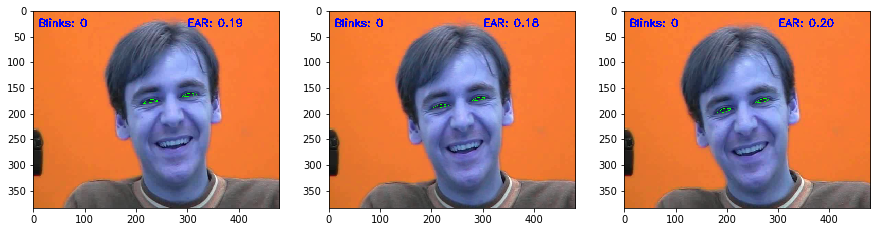

2th blink started at: 170th frame, middle of action at: 172th frame, ended at: 173th frame


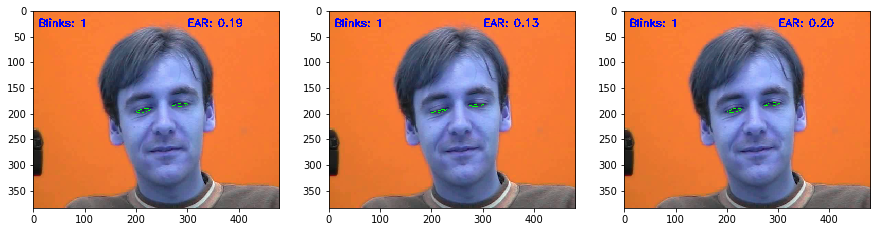

3th blink started at: 228th frame, middle of action at: 253th frame, ended at: 278th frame


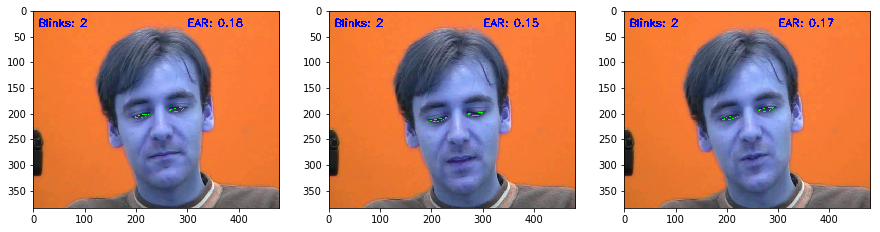

4th blink started at: 757th frame, middle of action at: 759th frame, ended at: 761th frame


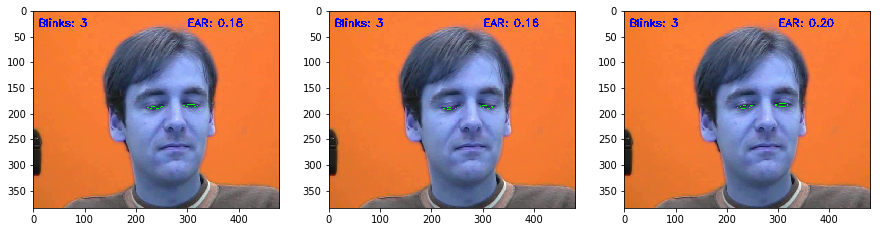

5th blink started at: 918th frame, middle of action at: 919th frame, ended at: 920th frame


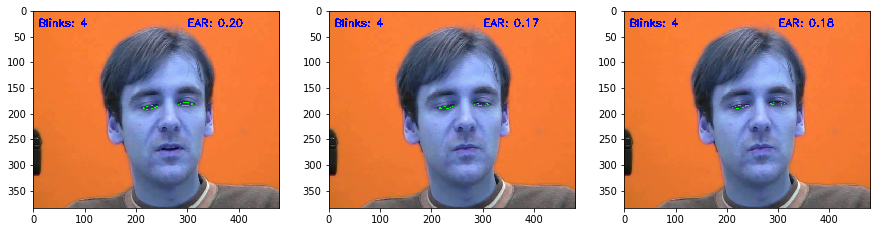

6th blink started at: 1108th frame, middle of action at: 1110th frame, ended at: 1111th frame


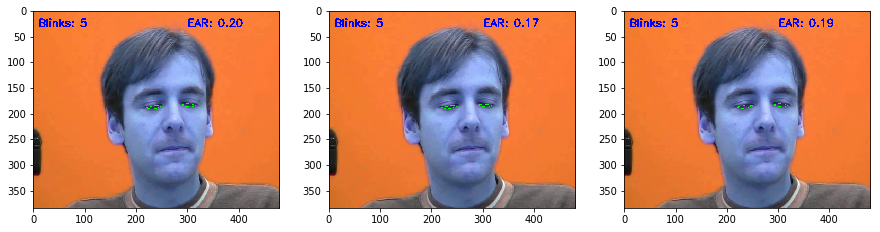

7th blink started at: 1125th frame, middle of action at: 1127th frame, ended at: 1129th frame


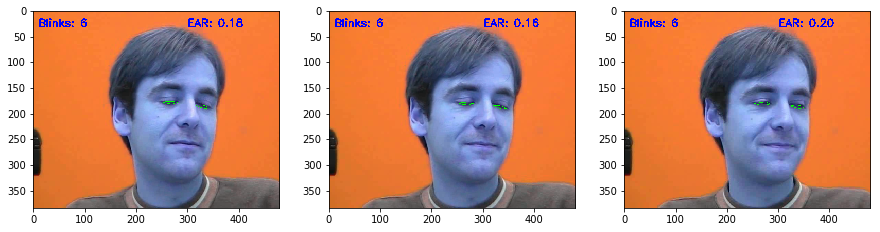

8th blink started at: 1201th frame, middle of action at: 1202th frame, ended at: 1203th frame


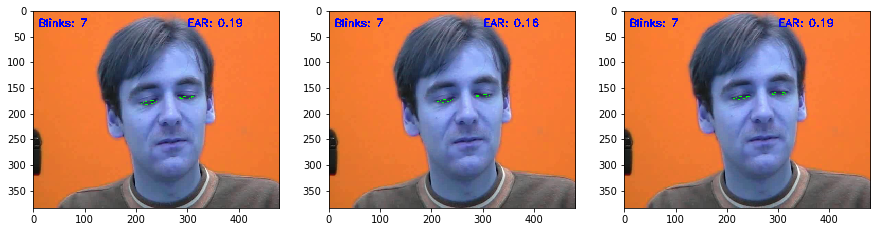

9th blink started at: 1242th frame, middle of action at: 1244th frame, ended at: 1246th frame


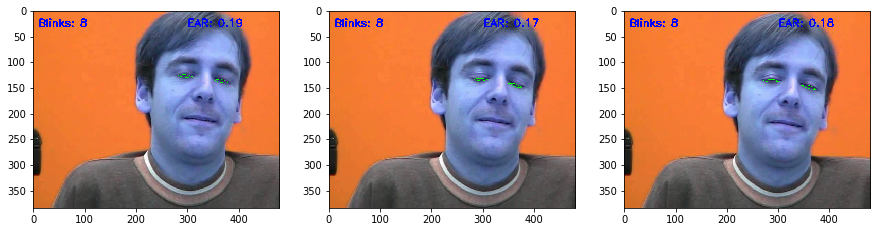

10th blink started at: 1449th frame, middle of action at: 1451th frame, ended at: 1453th frame


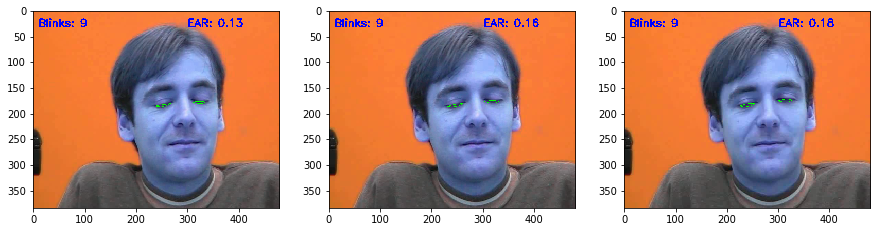

11th blink started at: 1487th frame, middle of action at: 1488th frame, ended at: 1489th frame


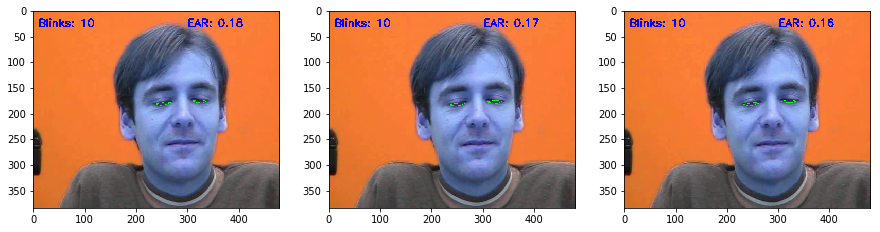

12th blink started at: 1811th frame, middle of action at: 1812th frame, ended at: 1813th frame


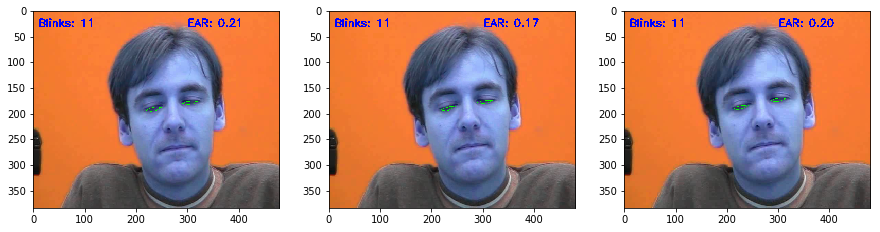

13th blink started at: 1833th frame, middle of action at: 1836th frame, ended at: 1838th frame


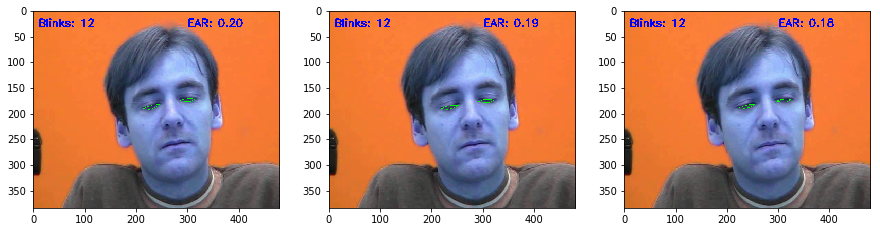

14th blink started at: 1960th frame, middle of action at: 1963th frame, ended at: 1966th frame


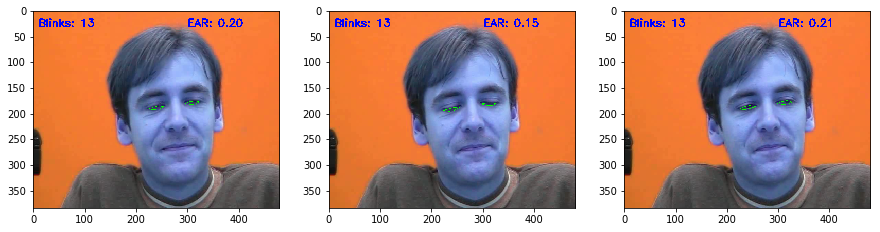

15th blink started at: 2004th frame, middle of action at: 2005th frame, ended at: 2006th frame


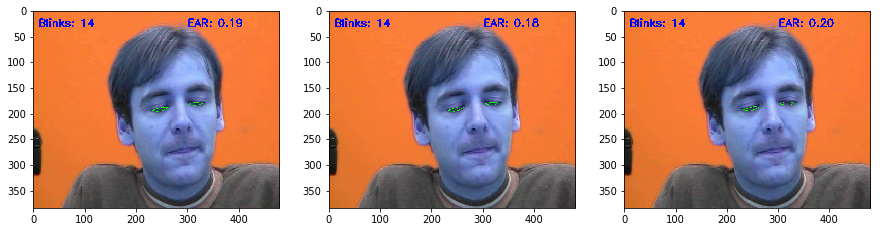

16th blink started at: 2120th frame, middle of action at: 2121th frame, ended at: 2122th frame


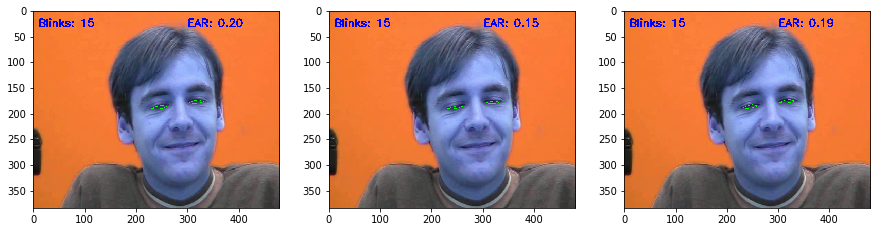

17th blink started at: 2274th frame, middle of action at: 2276th frame, ended at: 2277th frame


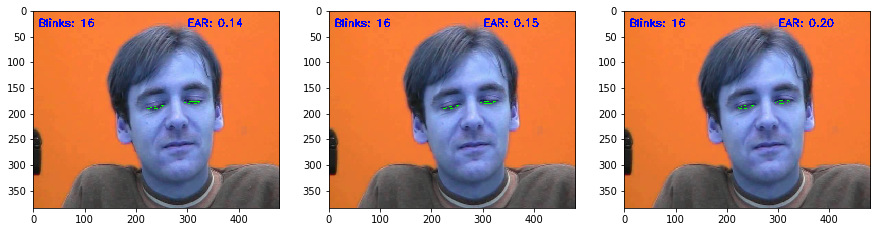

18th blink started at: 2467th frame, middle of action at: 2469th frame, ended at: 2471th frame


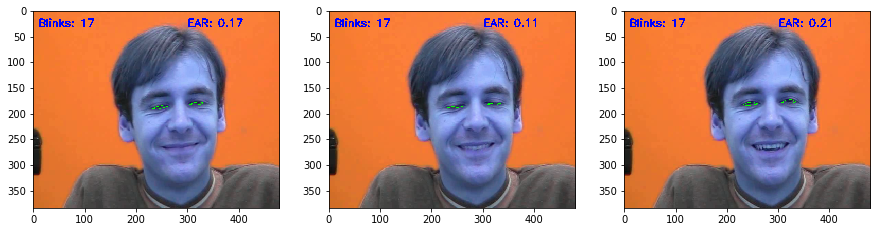

19th blink started at: 2494th frame, middle of action at: 2496th frame, ended at: 2497th frame


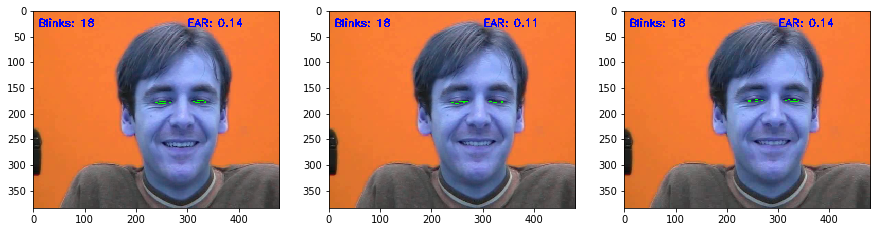

20th blink started at: 2510th frame, middle of action at: 2513th frame, ended at: 2516th frame


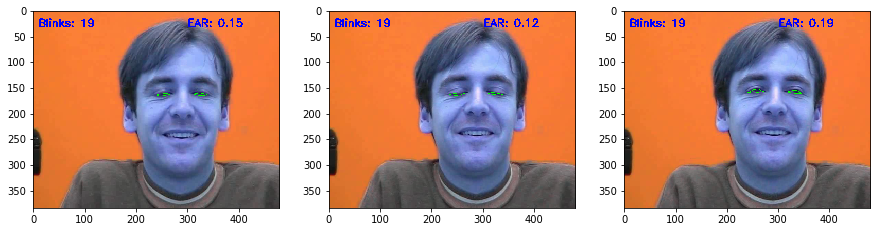

21th blink started at: 2525th frame, middle of action at: 2528th frame, ended at: 2530th frame


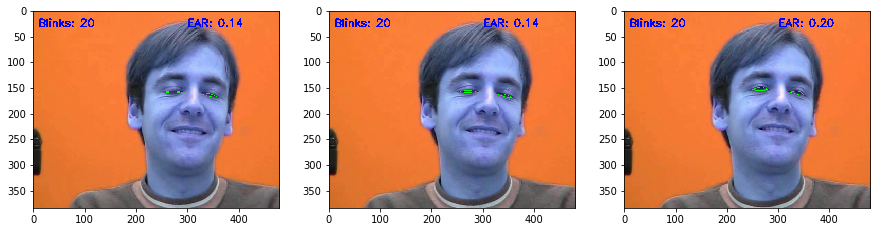

22th blink started at: 2627th frame, middle of action at: 2629th frame, ended at: 2631th frame


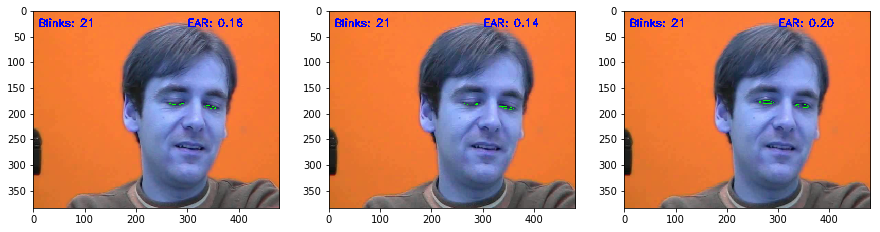

23th blink started at: 2698th frame, middle of action at: 2700th frame, ended at: 2701th frame


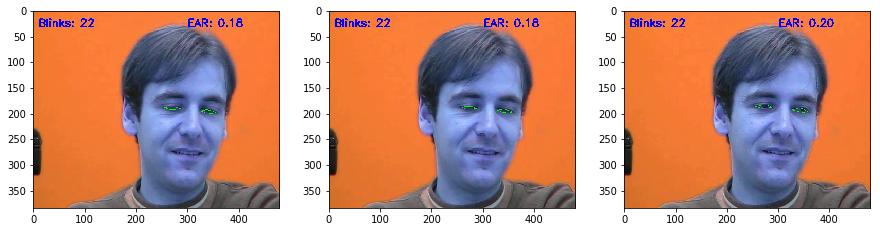

24th blink started at: 2756th frame, middle of action at: 2758th frame, ended at: 2760th frame


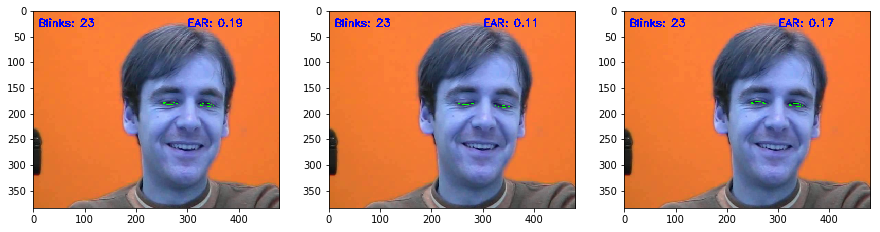

25th blink started at: 2885th frame, middle of action at: 2888th frame, ended at: 2890th frame


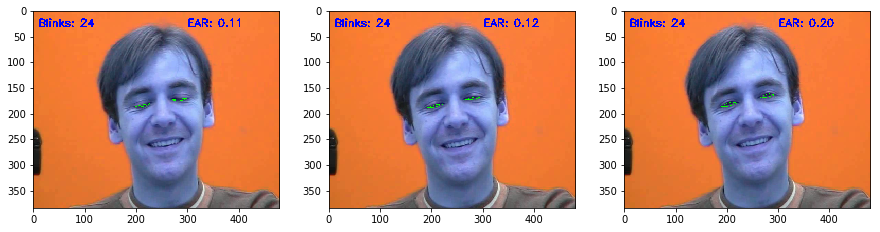

26th blink started at: 3007th frame, middle of action at: 3009th frame, ended at: 3010th frame


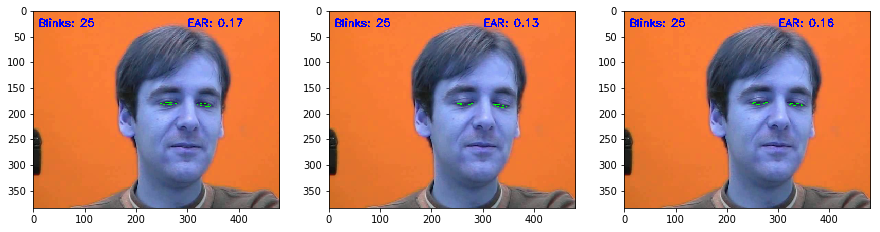

27th blink started at: 3048th frame, middle of action at: 3050th frame, ended at: 3052th frame


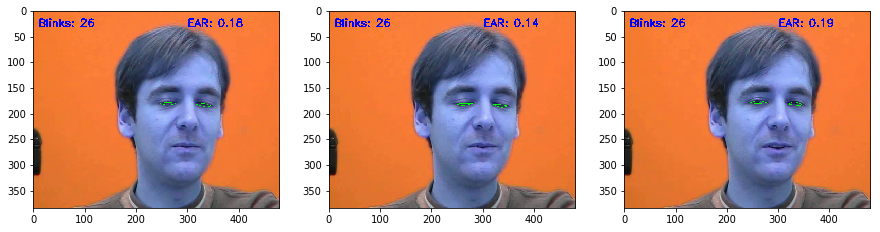

28th blink started at: 3193th frame, middle of action at: 3194th frame, ended at: 3195th frame


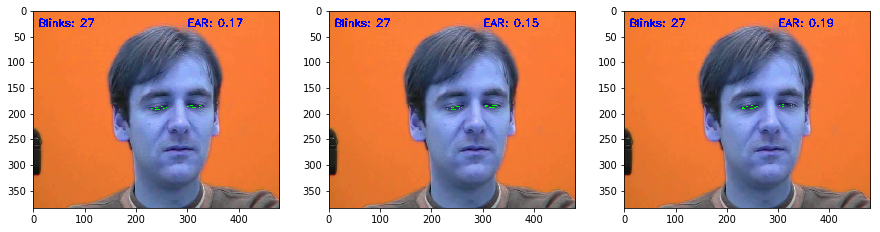

29th blink started at: 3248th frame, middle of action at: 3249th frame, ended at: 3250th frame


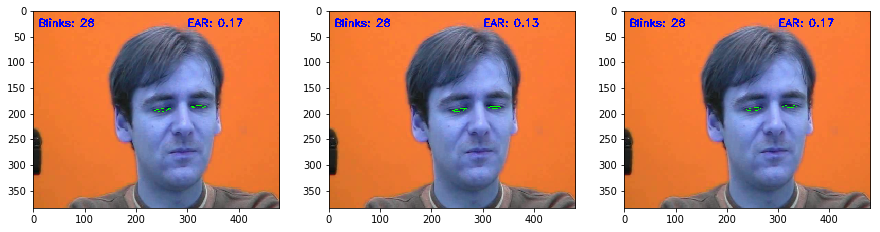

30th blink started at: 3259th frame, middle of action at: 3260th frame, ended at: 3261th frame


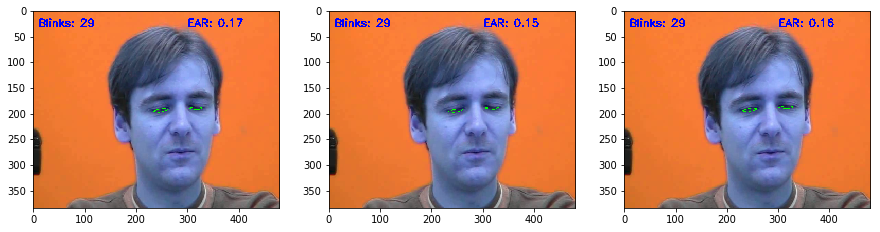

31th blink started at: 3360th frame, middle of action at: 3361th frame, ended at: 3362th frame


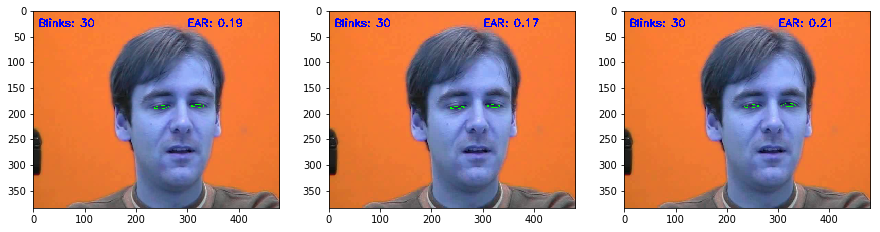

32th blink started at: 3604th frame, middle of action at: 3605th frame, ended at: 3606th frame


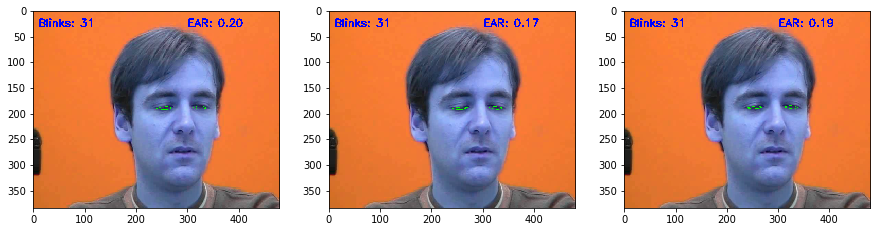

33th blink started at: 3974th frame, middle of action at: 3988th frame, ended at: 4002th frame


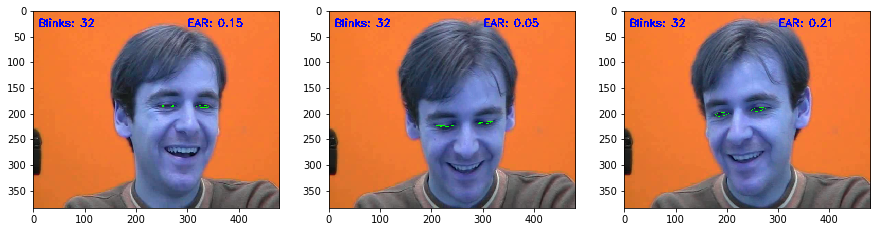

34th blink started at: 4180th frame, middle of action at: 4190th frame, ended at: 4199th frame


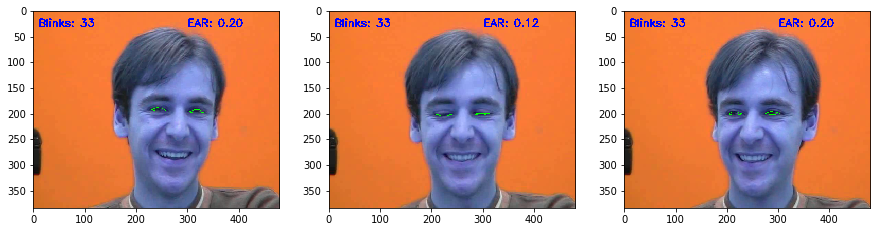

35th blink started at: 4221th frame, middle of action at: 4224th frame, ended at: 4227th frame


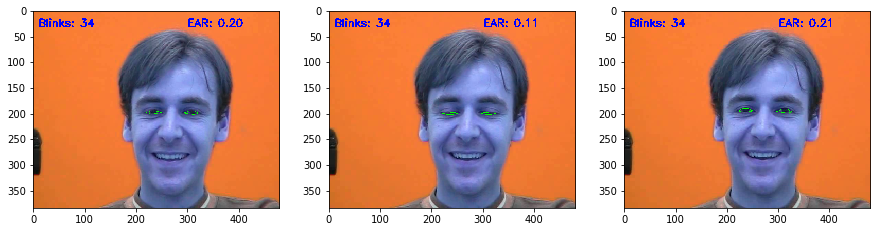

36th blink started at: 4230th frame, middle of action at: 4232th frame, ended at: 4233th frame


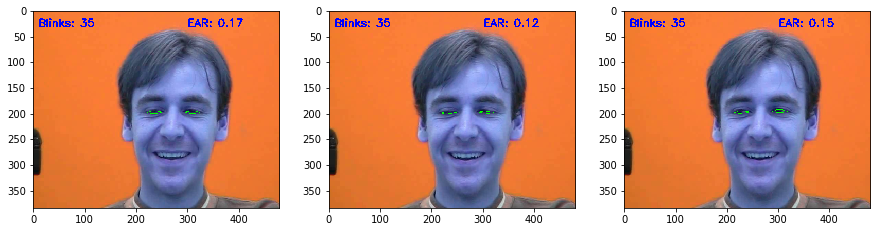

37th blink started at: 4303th frame, middle of action at: 4304th frame, ended at: 4305th frame


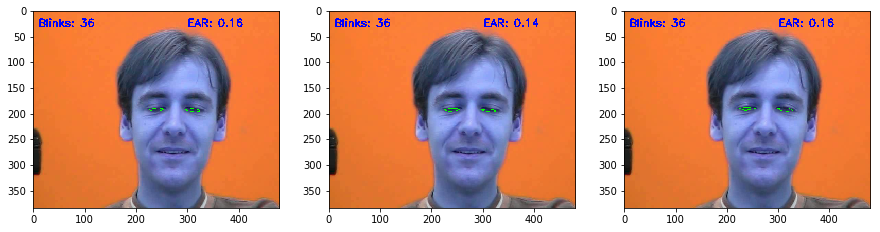

38th blink started at: 4313th frame, middle of action at: 4314th frame, ended at: 4315th frame


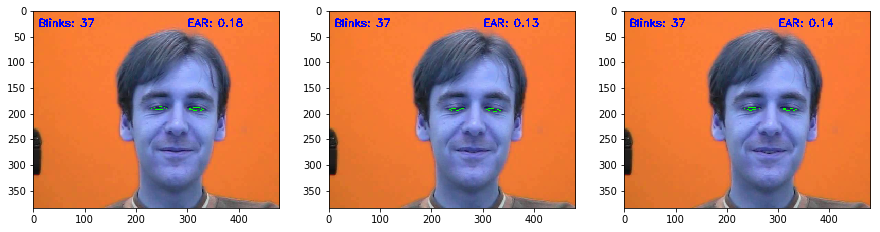

39th blink started at: 4323th frame, middle of action at: 4326th frame, ended at: 4328th frame


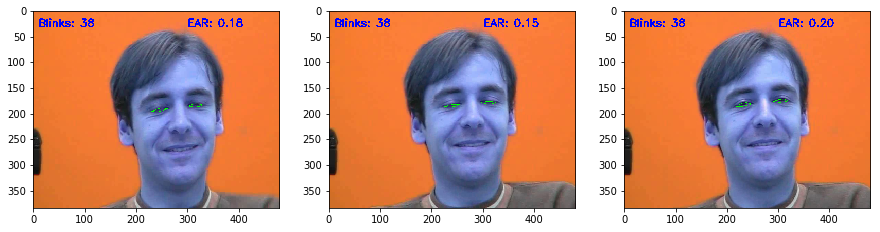

40th blink started at: 4353th frame, middle of action at: 4355th frame, ended at: 4356th frame


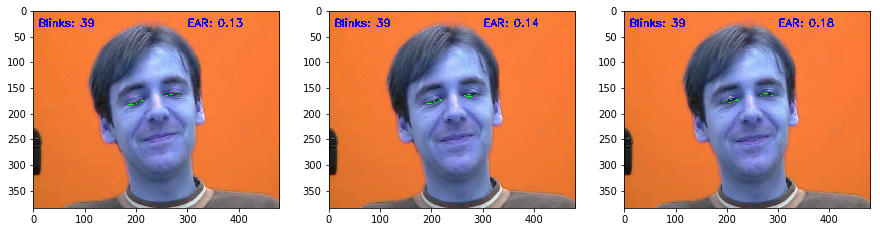

41th blink started at: 4402th frame, middle of action at: 4404th frame, ended at: 4406th frame


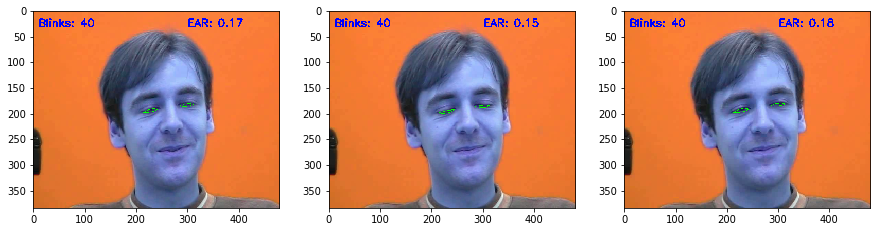

42th blink started at: 4604th frame, middle of action at: 4606th frame, ended at: 4608th frame


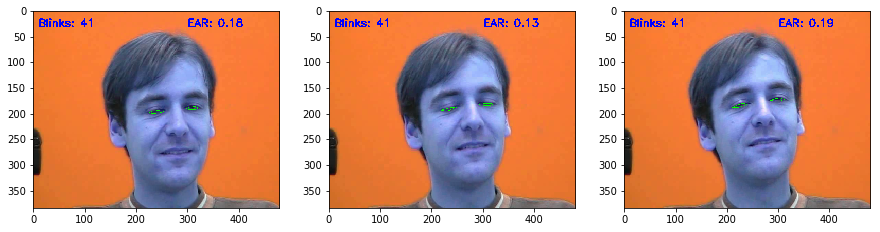

43th blink started at: 4663th frame, middle of action at: 4666th frame, ended at: 4668th frame


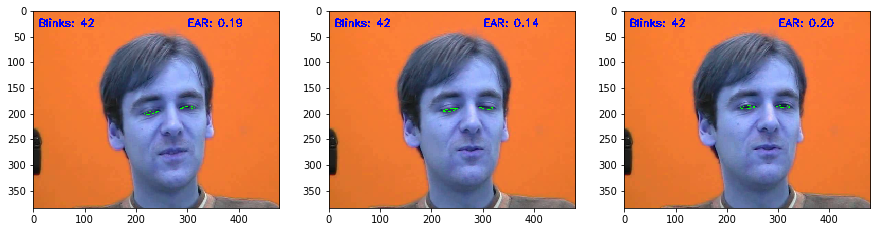

44th blink started at: 4724th frame, middle of action at: 4725th frame, ended at: 4726th frame


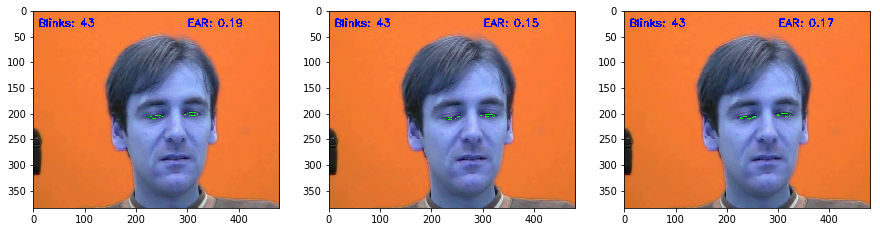

45th blink started at: 4882th frame, middle of action at: 4883th frame, ended at: 4884th frame


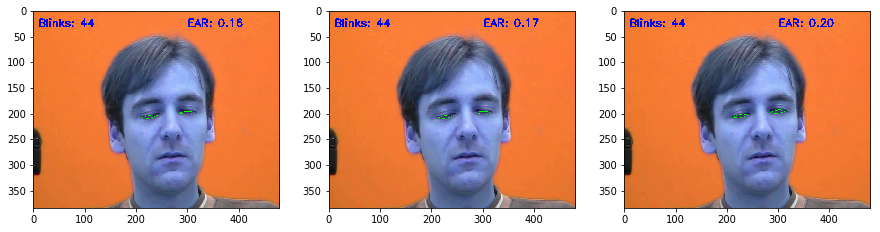

In [12]:
# display starting, middle and ending frames of all blinks by using "blinks" and "frames"
display_blinks(blink_predictions_skipped, frames_skipped)

**Read tag file of the video:**

We will read tag file (annotations made by https://www.blinkingmatters.com/research) to compare our predictions.  

But for an important note, we will compare closeness of eyes frame by frame, not the blinks for now.

The annotations starts with line "#start" and rows consist of the following information:  
> frame ID : blink ID : NF : LE_FC : LE_NV : RE_FC : RE_NV : F_X : F_Y: F_W : F_H : LE_LX : LE_LY : LE_RX : LE_RY: RE_LX : RE_LY : RE_RX : RE_RY

**frame ID** - Frame counter based on which the time-stamp can be obtained (separate file).  
**blink ID** - Unique blink ID, eye blink interval is defined as a sequence of the same blink ID frames.  
**non frontal face (NF)** - While subject is looking sideways and eye blink occurred, given variable changes from X to N.  
**left eye (LE), right eye (RE), face (F)**  
**eye fully closed (FC)** - If subject's eyes are closed from 90% to 100%, given flag will change from X to C.  
**eye not visible (NV)** - While subject's eye is not visible because of hand, bad light conditions, hair or even too fast head movement, this variable changes from X to N.  
**face bounding box (F_X,F_Y,F_W,F_H)** - x and y coordinates, width, height  
**left and right eye corners positions** - RX (right corner x coordinate), LY (left corner y coordinate)

So if a frame consist a blink it will be like:  
> 2851:9:X:X:X:X:X:240:204:138:122:258:224:283:225:320:226:347:224

A blink may consist fully closed eyes or not. If it consists fully closed eyes (90% - 100%, this scale is determined by **blinkmatters.com**) it's row will be like:  
> 2852:9:X:C:X:C:X:239:204:140:122:259:225:284:226:320:227:346:226

We are just interested in **blink ID** and **eye fully closed (FC)** columns, s we will only read  them, not other information. 

In [13]:
# read tag file and construct "closeness_list" and "blinks_list"
def read_annotations(input_file, skip_n = 0):
    # define variables 
    blink_start = 1
    blink_end = 1
    blink_info = (0,0)
    blink_list = []
    closeness_list = []

    # Using readlines() 
    file1 = open(input_file) 
    Lines = file1.readlines() 

    # find "#start" line 
    start_line = 1
    for line in Lines: 
        clean_line=line.strip()
        if clean_line=="#start":
            break
        start_line += 1

    # convert tag file to readable format and build "closeness_list" and "blink_list"
    for index in range(len(Lines[start_line+skip_n : -1])): # -1 since last line will be"#end"
        
        # read previous annotation and current annotation 
        prev_annotation=Lines[start_line+skip_n+index-1].split(':')
        current_annotation=Lines[start_line+skip_n+index].split(':')
        
        # if previous annotation is not "#start" line and not "blink" and current annotation is a "blink"
        if prev_annotation[0] != "#start\n" and prev_annotation[1] == "-1" and int(current_annotation[1]) > 0:
            # it means a new blink starts so save frame id as starting frame of the blink
            blink_start = int(current_annotation[0])
        
        # if previous annotation is not "#start" line and is a "blink" and current annotation is not a "blink"
        if prev_annotation[0] != "#start\n" and int(prev_annotation[1]) > 0 and current_annotation[1] == "-1":
            # it means a new blink ends so save (frame id - 1) as ending frame of the blink
            blink_end = int(current_annotation[0]) - 1
            # and construct a "blink_info" tuple to append the "blink_list"
            blink_info = (blink_start,blink_end)
            blink_list.append(blink_info)
        
        # if current annotation consist fully closed eyes, append it also to "closeness_list" 
        if current_annotation[3] == "C" and current_annotation[5] == "C":
            closeness_list.append(1)
        
        else:
            closeness_list.append(0)
    
    file1.close()
    return closeness_list, blink_list

**Read tag file:**  
by using read_annotations() function we just wrote.

For example you can use "../input/talkingFace/talking.tag" 

In [14]:
# full path of a tag file
file_path = "../input/talkingFace/talking.tag"

# read tag file
closeness_test, blinks_test = read_annotations(file_path, skip_n = SKIP_FIRST_FRAMES)

* **display tag results:**  
by using display_results() function we just wrote.

In [15]:
# display results by using outputs of read_annotations() function which are "closeness_test", "blinks_test"
scores_string += display_stats(closeness_test, blinks_test, skip_n = SKIP_FIRST_FRAMES, test = True)

Statistics on the test set are
TOTAL NUMBER OF FRAMES PROCESSED: 5000
NUMBER OF CLOSED FRAMES: 153
NUMBER OF BLINKS: 61




**Compare calculated blinks to test annotations:**

For now we will just compare our **basic model**'s predictions (eye closeness values, NOT blinks) to test results by defining a display_test_scores() function.

Later we will use same function to compare **adaptive model**'s predictions.

In [16]:
# display test scores and return an "output string" to pass it to writer function 
def display_test_scores(closeness_list_test, closeness_list_pred):
    str_out = ""
    str_out += ("EYE CLOSENESS FRAME BY FRAME TEST SCORES\n")
    str_out += ("\n")

    #print accuracy
    accuracy = accuracy_score(closeness_list_test, closeness_list_pred)
    str_out += ("ACCURACY: {:.4f}\n".format(accuracy))
    str_out += ("\n")

    #print AUC score
    auc = roc_auc_score(closeness_list_test, closeness_list_pred)
    str_out += ("AUC: {:.4f}\n".format(auc))
    str_out += ("\n")

    #print confusion matrix
    str_out += ("CONFUSION MATRIX:\n")
    conf_mat = confusion_matrix(closeness_list_test, closeness_list_pred)
    str_out += ("{}".format(conf_mat))
    str_out += ("\n")
    str_out += ("\n")

    #print FP, FN
    str_out += ("FALSE POSITIVES:\n")
    fp = conf_mat[1][0]
    pos_labels = conf_mat[1][0]+conf_mat[1][1]
    str_out += ("{} out of {} positive labels ({:.4f}%)\n".format(fp, pos_labels,fp/pos_labels))
    str_out += ("\n")

    str_out += ("FALSE NEGATIVES:\n")
    fn = conf_mat[0][1]
    neg_labels = conf_mat[0][1]+conf_mat[0][0]
    str_out += ("{} out of {} negative labels ({:.4f}%)\n".format(fn, neg_labels, fn/neg_labels))
    str_out += ("\n")

    #print classification report
    str_out += ("PRECISION, RECALL, F1 scores:\n")
    str_out += ("{}".format(classification_report(closeness_list_test, closeness_list_pred)))
    
    print(str_out)
    return str_out

**display test scores:**  
by using display_test_scores() function we just wrote.

In [17]:
# display results by using "closeness_predictions", "closeness_test"
scores_string += display_test_scores(closeness_test, closeness_predictions)

EYE CLOSENESS FRAME BY FRAME TEST SCORES

ACCURACY: 0.9640

AUC: 0.9656

CONFUSION MATRIX:
[[4672  175]
 [   5  148]]

FALSE POSITIVES:
5 out of 153 positive labels (0.0327%)

FALSE NEGATIVES:
175 out of 4847 negative labels (0.0361%)

PRECISION, RECALL, F1 scores:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4847
           1       0.46      0.97      0.62       153

    accuracy                           0.96      5000
   macro avg       0.73      0.97      0.80      5000
weighted avg       0.98      0.96      0.97      5000



**We define a function that writes output files:**  

In [18]:
# write output files of model which are closeness_list, blinks_list and optionally frame_info_df and scores
# if you are writing test dataset results, set test=True so it will change output file's names to "_test" 
# if you want write only scores, not the other files, then set it to scores_only=True
def write_outputs(input_file_name, closeness_list, blinks_list, frame_info_df=None, scores=None, \
                  test=False, scores_only=False):
    # clean filename from path and extensions so you can pass input_file variable to function as it is.
    clean_filename=os.path.basename(os.path.splitext(input_file_name)[0])
    
    # if you are writing prediction outputs
    if test == False and scores_only == False:
        #write all lists to single .h5 file
        with h5py.File("{}_pred.h5".format(clean_filename), "w") as hf:
            g = hf.create_group('pred')
            g.create_dataset('closeness_list',data=closeness_list)
            g.create_dataset('blinks_list',data=blinks_list)
            if frame_info_df is not None:
                frame_info_df.to_parquet('{}_frame_info_df.parquet'.format(clean_filename), engine='pyarrow')
            
    # if you are writing test outputs
    if test == True and scores_only == False:
        #write all lists to single .h5 file
        with h5py.File("{}_test.h5".format(clean_filename), "w") as hf:
            g = hf.create_group('test')
            g.create_dataset('closeness_list',data=closeness_list)
            g.create_dataset('blinks_list',data=blinks_list)
            if frame_info_df is not None:
                frame_info_df.to_parquet('{}_frame_info_df.parquet'.format(clean_filename), engine='pyarrow')

   # if you are writing scores
    if scores != None:
        # use text files this time
        with open("{}_scores.txt".format(clean_filename),"w", encoding='utf-8') as f:
            f.write(scores)
    return

**write output files:**  
by using write_outputs() function we just wrote.

In [19]:
# write prediction output files by using outputs of skip_first_n_frames() function
write_outputs(file_path, closeness_predictions_skipped, blink_predictions_skipped, \
              frame_info_df, scores_string)

# write test output files by using outputs of skip_first_n_frames() function
# no need to write frame_info_df and scores_string since they already have written above
write_outputs(file_path, closeness_test, blinks_test, test = True)

**We define a function that reads output files to use it later purposes:**  

In [20]:
# read output files. 
# if you want to get prediction results, use test=False
# if you want to get test results set test=True
def read_outputs(h5_name, parquet_name=None, test=False):
    # read h5 file by name
    hf = h5py.File('{}.h5'.format(h5_name), 'r')
    
    # if you are reading prediction results
    if test == False:  
        g = hf.get("pred") # read group first   
        
    # if you are reading test results
    if test == True:
         g = hf.get("test") # read group first  
            
    # then get datasets
    closeness_list = list(g.get('closeness_list'))
    blink_list = list(g.get('blinks_list'))

    # if you want to read frame_df_info
    if parquet_name != None:
        frame_info_df = pd.read_parquet('{}.parquet'.format(parquet_name), engine='pyarrow')
        return closeness_list, blink_list, frame_info_df
    
    # if you don't want to read frame_df_info
    else:
        return closeness_list, blink_list

**We define a function to read all of output files:**

In [21]:
# load all of output files. 
def load_datasets(path, dataset_name):
    # build  full path
    full_path = os.path.join(path, dataset_name)
    
    # read prediction results and frame_info_df
    closeness_pred, blinks_pred, frame_info_df \
                = read_outputs("{}_pred".format(full_path),"{}_frame_info_df".format(full_path))

    # read test results
    closeness_test, blinks_test = read_outputs("{}_test".format(full_path), test = True)
    
    # read scores
    with open("{}_scores.txt".format(full_path),"r") as f:
        Lines = f.readlines() 
        # build a string that hold scores
        scores_str = ""
        for line in Lines: 
            scores_str += line

    return  closeness_pred, blinks_pred, frame_info_df, closeness_test, blinks_test, scores_str

**Load datasets by reading all of output files:**

We will call this function on next notebooks. This way, by reading outputs of previous notebooks, we will build a basic pipeline.

In [22]:
# load datasets
c_pred, b_pred, df, c_test, b_test, s_str= load_datasets("../working","talking")

# check results
print(np.array(c_pred).shape, np.array(b_pred).shape)
print(np.array(c_test).shape, np.array(b_test).shape)
print()
print(s_str)
df

(5000,) (45, 2)
(5000,) (61, 2)

Processing talking.avi has done.

Video info
FPS: 30.0
FRAME_COUNT: 5000
DURATION (s): 166.67

Statistics on the prediction set are
TOTAL NUMBER OF FRAMES PROCESSED: 5000
NUMBER OF CLOSED FRAMES: 323
NUMBER OF BLINKS: 45

Statistics on the test set are
TOTAL NUMBER OF FRAMES PROCESSED: 5000
NUMBER OF CLOSED FRAMES: 153
NUMBER OF BLINKS: 61

EYE CLOSENESS FRAME BY FRAME TEST SCORES

ACCURACY: 0.9640

AUC: 0.9656

CONFUSION MATRIX:
[[4672  175]
 [   5  148]]

FALSE POSITIVES:
5 out of 153 positive labels (0.0327%)

FALSE NEGATIVES:
175 out of 4847 negative labels (0.0361%)

PRECISION, RECALL, F1 scores:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4847
           1       0.46      0.97      0.62       153

    accuracy                           0.96      5000
   macro avg       0.73      0.97      0.80      5000
weighted avg       0.98      0.96      0.97      5000



frame_no  face_detected  \
0            1           True   
1            2           True   
2            3           True   
3            4           True   
4            5           True   
...        ...            ...   
4995      4996           True   
4996      4997           True   
4997      4998           True   
4998      4999           True   
4999      5000           True   

                                      face_coordinates  \
0     [[174, 114], [353, 114], [174, 293], [353, 293]]   
1     [[174, 114], [353, 114], [174, 293], [353, 293]]   
2     [[174, 114], [353, 114], [174, 293], [353, 293]]   
3     [[174, 114], [353, 114], [174, 293], [353, 293]]   
4     [[174, 114], [353, 114], [174, 293], [353, 293]]   
...                                                ...   
4995  [[194, 154], [373, 154], [194, 333], [373, 333]]   
4996  [[194, 154], [373, 154], [194, 333], [373, 333]]   
4997  [[194, 154], [373, 154], [194, 333], [373, 333]]   
4998  [[194, 154], [373, 154], [194, 333], [373, 333]]   
4999  [[161, 137], [376, 137], [161, 352], [376, 352]]   

          left_eye_coordinates     right_eye_coordinates  left_ear  right_ear  \
0     [[276, 167], [286, 158]]  [[202, 179], [210, 170]]  0.304218   0.320053   
1     [[277, 167], [286, 158]]  [[203, 180], [211, 170]]  0.306832   0.334046   
2     [[277, 167], [287, 158]]  [[204, 181], [212, 171]]  0.297228   0.313230   
3     [[279, 168], [289, 159]]  [[205, 181], [213, 172]]  0.306577   0.297228   
4     [[280, 168], [290, 159]]  [[206, 182], [215, 172]]  0.304218   0.308679   
...                        ...                       ...       ...        ...   
4995  [[299, 196], [309, 187]]  [[226, 199], [235, 190]]  0.397098   0.359200   
4996  [[299, 197], [309, 187]]  [[226, 199], [235, 191]]  0.396392   0.343582   
4997  [[299, 196], [309, 187]]  [[226, 199], [235, 191]]  0.379867   0.344291   
4998  [[299, 196], [310, 187]]  [[226, 199], [235, 190]]  0.383176   0.344232   
4999  [[299, 197], [310, 187]]  [[226, 199], [236, 190]]  0.354833   0.333180   

       avg_ear  closeness  blink_no  blink_start_frame  blink_end_frame  \
0     0.312135          0         0                  0                0   
1     0.320439          0         0                  0                0   
2     0.305229          0         0                  0                0   
3     0.301903          0         0                  0                0   
4     0.306449          0         0                  0                0   
...        ...        ...       ...                ...              ...   
4995  0.378149          0        45               4882             4884   
4996  0.369987          0        45               4882             4884   
4997  0.362079          0        45               4882             4884   
4998  0.363704          0        45               4882             4884   
4999  0.344007          0        45               4882             4884   

      reserved_for_calibration  
0                        False  
1                        False  
2                        False  
3                        False  
4                        False  
...                        ...  
4995                     False  
4996                     False  
4997                     False  
4998                     False  
4999                     False  

[5000 rows x 13 columns]

**And finally let's put it all together to build a model:**

In [23]:
# build simple_model pipeline
# if you want to display blinks set display_blinks=True (it requires long time and memory so default is False)
# if you want to read annotation file and run comparison metrics set test_extention="tag" or any file extension
# REMARK: your annotation file an video file must have the same name to use this function.
# if you want to write outputs set write_results=True
def simple_model(input_full_path, ear_th=0.21, consec_th=3, skip_n = 0, \
                    display_blinks=False, test_extention=False, write_results=False):
    # define variables
    scores_string = ""
    
    # process the video and get the results
    frame_info_df, closeness_predictions, blink_predictions, frames, video_info, scores_string \
        = process_video(input_full_path, ear_th=ear_th, consec_th=consec_th)
    
    # recalculate data by skipping "skip_n" frames
    frame_info_df, closeness_predictions_skipped, blink_predictions_skipped, frames_skipped \
        = skip_first_n_frames(frame_info_df, closeness_predictions, blink_predictions, frames, \
                              skip_n = skip_n)

    # first display statistics by using original outputs
    scores_string += display_stats(closeness_predictions, blink_predictions, video_info)

    # then display statistics by using outputs of skip_first_n_frames() function which are 
    #"closeness_predictions_skipped" and "blinks_predictions_skipped"
    if(skip_n > 0):
        scores_string += display_stats(closeness_predictions_skipped, blink_predictions_skipped, video_info, \
                                 skip_n = skip_n)
    
    # if you want to display blinks
    if display_blinks == True:
        # display starting, middle and ending frames of all blinks by using "blinks" and "frames"
        display_blinks(blink_predictions_skipped, frames_skipped)
        
    # if you want to read tag file
    if test_extention != False:
        extention = ""
        # default file extension is ".tag"
        if test_extention == True:
            extention = "tag"
        else:
            extention = test_extention
        # remove video extention i.e. ".avi"
        clean_path = os.path.splitext(input_full_path)[0]
        # read tag file
        closeness_test, blinks_test = read_annotations("{}.{}".format(clean_path, extention), skip_n = skip_n)
        # display results by using outputs of read_annotations() function 
        # which are "closeness_test", "blinks_test"
        scores_string += display_stats(closeness_test, blinks_test, skip_n = skip_n, test = True)
        # display results by using "closeness_test" and "closeness_predictions"
        scores_string += display_test_scores(closeness_test, closeness_predictions_skipped)
        
    # if you want to write results
    if write_results == True:
        # write prediction output files by using outputs of skip_first_n_frames() function
        write_outputs(input_full_path, closeness_predictions_skipped, blink_predictions_skipped, \
                      frame_info_df, scores_string)
        if test_extention != False:
            # write test output files by using outputs of skip_first_n_frames() function
            # no need to write frame_info_df and scores_string since they already have written above
            write_outputs(input_full_path, closeness_test, blinks_test, \
                          test = True)
            
    return frame_info_df, closeness_predictions_skipped, blink_predictions_skipped, frames_skipped, \
            video_info, scores_string

**Let's test the function simple_model():**

We can use one of the videos of other dataset (eyeblink8)  
i.e "../input/eyeblink8/8/27122013_151644_cam.avi".  
This may take a long time like 10-15 mins due to it's large size.

**NOTE TO MYSELF:** eyeblink8/1 doesn't work. There are inconsistency on frame counts between test and pred results. check version 16. eyeblink8/8 works well. others also need to be checked.

In [24]:
# test the function above
fdf, cp, bp, fr, vi, st = simple_model("../input/eyeblink8/8/27122013_151644_cam.avi", \
                                    test_extention = "tag", write_results = True)

Processing 27122013_151644_cam.avi has done.


Video info
FPS: 30.0
FRAME_COUNT: 10712
DURATION (s): 357.07

Statistics on the prediction set are
TOTAL NUMBER OF FRAMES PROCESSED: 10663
NUMBER OF CLOSED FRAMES: 626
NUMBER OF BLINKS: 51


Statistics on the test set are
TOTAL NUMBER OF FRAMES PROCESSED: 10663
NUMBER OF CLOSED FRAMES: 107
NUMBER OF BLINKS: 30


EYE CLOSENESS FRAME BY FRAME TEST SCORES

ACCURACY: 0.9510

AUC: 0.9660

CONFUSION MATRIX:
[[10035   521]
 [    2   105]]

FALSE POSITIVES:
2 out of 107 positive labels (0.0187%)

FALSE NEGATIVES:
521 out of 10556 negative labels (0.0494%)

PRECISION, RECALL, F1 scores:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     10556
           1       0.17      0.98      0.29       107

    accuracy                           0.95     10663
   macro avg       0.58      0.97      0.63     10663
weighted avg       0.99      0.95      0.97     10663

